# <Font color = 'indianred'>**1. Set Environment**

*Mount Google Drive, Install libraries, specify basepath*

In [1]:
# If in Colab, then import the drive module from google.colab
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output

  !pip install torchtext -qq
  # Install the torchinfo library quietly
  !pip install torchinfo -qq
  !pip install torchtext --upgrade -qq
  !pip install torchmetrics -qq
  !pip install torchinfo -qq
  !pip install fast_ml -qq
  !pip install joblib -qq
  !pip install sklearn -qq
  !pip install pandas -qq
  !pip install numpy -qq
  !pip install scikit-multilearn -qq
  !pip install transformers evaluate wandb accelerate -U -qq

  basepath = '/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing'
  sys.path.append('/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Custom_files')
else:
  basepath = '/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/'
  sys.path.append('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Custom_files')
  !pip install torchtext -qq
  # Install the torchinfo library quietly
  !pip install torchinfo -qq
  !pip install torchtext --upgrade -qq
  !pip install torchmetrics -qq
  !pip install torchinfo -qq
  !pip install fast_ml -qq
  !pip install joblib -qq
  !pip install sklearn -qq
  !pip install pandas -qq
  !pip install numpy -qq
  !pip install scikit-multilearn -qq
  !pip install transformers evaluate wandb accelerate -U -qq

*Import Libraries*

In [2]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab
from torchinfo import summary

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from types import SimpleNamespace
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt

import ast
from sklearn.preprocessing import MultiLabelBinarizer
from fast_ml.model_development import train_valid_test_split
from skmultilearn.model_selection import iterative_train_test_split
import pandas as pd


# For creating lightweight attribute classes and for partial function application
from types import SimpleNamespace
from functools import partial

# Import HammingDistance from torchmetrics
# HammingDistance is useful for evaluating multi-label classification problems.
from torchmetrics import HammingDistance

from torch.nn.utils import clip_grad_value_

from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report

/opt/homebrew/anaconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'seaborn'

*Specify Project Folders*

In [ ]:
# Set the base folder path using the Path class for better path handling
base_folder = Path(basepath)

# Define the data folder path by appending the relative path to the base folder
# This is where the data files will be stored
data_folder = base_folder / '0_Data_Folder'

# Define the model folder path for saving trained models
# This path points to a specific folder designated for NLP models related to the IMDb dataset
model_folder = data_folder

custom_functions = base_folder / '0_Custom_files' 


In [ ]:
# Create the model folder directory. If it already exists, do nothing.
# The 'parents=True' argument ensures that all parent directories are created if they don't exist.
model_folder.mkdir(exist_ok=True, parents=True)

# Create the data folder directory in a similar manner.
data_folder.mkdir(exist_ok=True, parents=True)


# <Font color = 'indianred'>**2. Load Data** </font>

**IMDB movie review dataset**

For this tutorial, we will use the *IMDB movie review dataset*, which is widely recognized for sentiment analysis tasks. It consists of movie reviews from the IMDB website.

- This is a dataset for binary sentiment classification i.e. it has two outputes (positive sentiment and negative sentiment). The dataset has a set of 25,000 movie reviews for training, and 25,000 for testing.

- The labels for this dataset are binary, reflecting positive or negative sentiments. A label of '0' typically represents a negative sentiment, while a label of '1' signifies a positive sentiment.

- The dataset can be accessed via the following link: http://ai.stanford.edu/~amaas/data/sentiment/

**Data Preprocessing Steps Undertaken:**

1. **Initial Cleaning:** We cleaned the raw data by removing HTML tags, punctuation, and standardizing the text to lowercase to ensure uniformity and aid model training.

2. **Dataset Splits:** We divided the dataset into training, validation, and test sets. This separation is crucial for training, fine-tuning, and objectively evaluating the performance of our models.

3. **Serialization of Data:** To facilitate ease of access during model training and testing, we serialized the processed splits into separate files using the `joblib` library.

**Files provided**

To facilitate your work with this dataset, we have provided three serialized files corresponding to the training, validation, and test splits. Each file contains a tuple, where:

- The first element is a list of reviews, representing the preprocessed textual data from movie reviews.
- The second element is a numpy array of labels, where each label corresponds to the sentiment of a review (0 for negative, 1 for positive).

In [ ]:
X_train_cleaned_file = data_folder / 'df_multilabel_hw_cleaned.joblib'

data = joblib.load(X_train_cleaned_file)

In [ ]:

data.head()

- The `joblib.load` function is used to load the data from the `.pkl` files. Each file contains two elements:
  - The first element (`X_train_cleaned`, `X_valid_cleaned`, `X_test_cleaned`) contains the preprocessed reviews.
  - The second element (`y_train`, `y_valid`, `y_test`) contains the corresponding labels for these reviews.



In [ ]:
arr = []

x = []

for i in range(data.shape[0]):
    arr.append(ast.literal_eval(data['Tag_Number'][i]))
    x.append(str(data['cleaned_text'][i]))

x = np.array(x).reshape(-1,1)

numpy.ndarray

In [ ]:
mlb = MultiLabelBinarizer()

y = mlb.fit_transform(arr)

print(type(y) , y.shape)
print(type(x) , x.shape)

list

# <Font color = 'indianred'>**3. Custom Dataset Class**

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading IMDB reviews and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Storing feature data (texts)
        self.X = X

        # Storing the target labels
        self.y = y

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample


In [ ]:


# Create an instance of the CustomDataset class for the training set
# This uses the cleaned training data and corresponding labels
trainset = CustomDataset(X_train_cleaned, y_train)

# Create an instance of the CustomDataset class for the validation set
# This uses the cleaned validation data and corresponding labels
validset = CustomDataset(X_valid_cleaned, y_valid)

# Create an instance of the CustomDataset class for the test set
# This uses the cleaned test data and corresponding labels
testset = CustomDataset(X_test_cleaned, y_test)


In [ ]:
# Access the text of the sixth sample in the training dataset
# notice the difference between the outputs of 2 pprint.
pprint(trainset[5])
print()
text_of_sixth_sample = trainset[5][1]

# Use pprint to print the text of the sixth sample with a specified width of 80 characters for better readability
pprint(text_of_sixth_sample, width=80)

type(text_of_sixth_sample)


(1,
 'aware steve mcqueen 1958 know extremely frightened go film devastate movie '
 'trantula age seven 1st scene blob crawl farmer probe stick engulfs hand want '
 'leave theater stay suffer monster attack feel horror steve girl barely '
 'doctor office poor doc blob enter movie theater devour large portion '
 'audience fact oooooozzzzzze door huge fit indestructible unlimited growth '
 'potential trap poor steve sieve like diner like sure dinner blob cold modern '
 'day description end well icy scare mentally rupture little kid remember walk '
 'home evening uncle nick try act brave know trouble get bed night feel blob '
 'room summon courage look floor red pulsating heart like hungry dude sit wait '
 'try bathroom take month recover 57 year old course blob destroy')

('aware steve mcqueen 1958 know extremely frightened go film devastate movie '
 'trantula age seven 1st scene blob crawl farmer probe stick engulfs hand want '
 'leave theater stay suffer monster attack feel horror stev

str

In [ ]:
# Access the label of the second sample in the training dataset
# 'trainset[1]' fetches the sixth sample (since indexing starts at 0), and '[0]' accesses the label of this sample
label_of_sixth_sample = trainset[5][0]
label_of_sixth_sample

1

# <Font color = 'indianred'>**4. Create Vocab** </font>
The `get_vocab` function is designed to generate a vocabulary from a given dataset. We went through the steps for craeting vocab in previous notebook. We have now created a function for that. Here's a concise explanation of what it does:

1. **Initializing a Counter:**
   - A `Counter` object is created to tally the frequency of each token (word) found in the dataset.

2. **Token Frequency Counting:**
   - The function iterates through the dataset, which is a list of tuples containing labels and texts. For each text, it splits the text into tokens and updates the counter with these tokens.

3. **Creating the Vocabulary:**
   - A `torchtext.vocab.vocab` object is created using the counter. This vocabulary contains tokens that meet or exceed the specified minimum frequency (`min_freq`).
   - Tokens appearing less frequently than `min_freq` are excluded from the vocabulary.

4. **Handling Unknown Words:**
   - The special token `<unk>` (representing unknown words) is inserted at index 0 in the vocabulary.
   - The default index of the vocabulary is set to 0. This ensures that any token not found in the vocabulary will be mapped to `<unk>`.

5. **Return Value:**
   - The function returns the constructed `Vocab` object, which can then be used to convert tokens to indices or vice versa.

In summary, `get_vocab` automates the process of creating a vocabulary from textual data, ensuring that only sufficiently frequent words are included and providing a mechanism to handle unknown words.

In [ ]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (list of tuple): List of tuples where each tuple contains a label and a text.
        min_freq (int): The minimum frequency for a token to be included in the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    for (label, text) in dataset:
        counter.update(text.split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab

<Font color = 'indianred'>**Vocab should always be created based on trainset** </font>

In sentiment analysis and other natural language processing tasks, it's crucial to create the model's vocabulary exclusively from the training set to avoid data leakage and ensure realistic model training. Data leakage can occur if the vocabulary includes words from the test set, leading to overly optimistic performance estimates and poor generalization to new data. Using only the training set helps simulate real-world conditions where the model encounters unseen data, allows for effective strategies to handle unknown words, and ensures statistical representativeness. This approach is vital for developing robust models that perform well on real-world data and for maintaining consistency and fairness in model evaluation.

In [ ]:
imdb_vocab = get_vocab(trainset, min_freq=2)

In [ ]:
len(imdb_vocab)

36153

In [ ]:
imdb_vocab.get_itos()[0:5]

['<unk>', 'george', 'brent', 'reporter', 'send']

`imdb_vocab.get_itos()[0:5]` retrieves the first five words or tokens from the IMDb dataset vocabulary and returns them as a list.`itos` stands for index to string

In [ ]:
imdb_vocab['abracadabra']

0

# <Font color = 'indianred'>**5. Collate_fn for Data Loaders** </font>



In [ ]:
# Creating a function that will be used to get the indices of words from vocab
def tokenizer(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in x.split()]

In [ ]:
def collate_batch(batch, my_vocab):
    """
    Collates a batch of samples into tensors of labels, texts, and offsets.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing three tensors:
               - Labels tensor
               - Concatenated texts tensor
               - Offsets tensor indicating the start positions of each text in the concatenated tensor
    """
    # Unpack the batch into separate lists for labels and texts
    labels, texts = zip(*batch)

    # Convert the list of labels into a tensor of dtype int32
    labels = torch.tensor(labels, dtype=torch.long)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all text indices into a single tensor
    indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return (indices, offsets), labels

Note:
* We convert label to PyTorch long format because it is required by loss function, nn.CrossEntropy().
* label needs to be converted to PyTorch float format in case of nn.BCEWithLogitsLoss(), which we use for multi-label classification.

## <Font color = 'indianred'>*Check collate function*

Let us test if our collate function is working by creating a dataloader.

In PyTorch, the `DataLoader` requires the `collate_fn` to be a function that accepts only a single argument (the batch of data). However, if you have a collate function like `collate_batch` that needs an additional argument (like a vocabulary), you can't pass this extra argument directly within `DataLoader`. This is where the `partial` function from Python's `functools` module becomes essential.

**The `partial` Function**

- **Functionality:** `partial` is a higher-order function that allows you to "freeze" a certain number of arguments of a function, creating a new function with fewer required arguments.
- **Context of Use:** In this case, `partial` is used to create a new version of the `collate_batch` function. By using `partial(collate_batch, my_vocab=imdb_vocab)`, a new function is generated where `my_vocab` is always set to `imdb_vocab`.

In [ ]:
batch_size = 2
collate_partial = partial(collate_batch, my_vocab = imdb_vocab)
check_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           collate_fn=collate_partial,
                                           )

In [ ]:
torch.manual_seed(22)
for (indices, offset), label in check_loader:
    print(indices, offset, label)
    break


tensor([ 2644, 10417,  1560,    42,   205,  4201,  2225, 11426,   688,  6568,
          879,   435,   655,  1514,  6239,  1451,     0,  5564, 15153,   239,
        12797, 15152,    51,   229,   679,  5201, 14646,  1215,   402,   814,
           75,   112,    37,   137,   210,   206,   226,  4572,  1538,  9318,
          606,  9338, 13643,  1666,    75,   255,  1561,   112,  5459, 24297,
          231,    42,    27,    75,   868,  2704,  4721,  2815,  2826,    42,
         1555,    42,  1227]) tensor([ 0, 30]) tensor([0, 0])


The output you're seeing is from iterating over the `check_loader`, a `DataLoader` instance in PyTorch. This output represents one batch from your dataset. Let's break down what each component means:

1. **Tensor of Word Indices (`text`):**
   - This is a flattened tensor containing the numerical indices of words from the reviews in the batch. Each number corresponds to a word's index in the vocabulary (`imdb_vocab`).
   - These indices are generated by converting words in the text to their respective indices based on the vocabulary created earlier.

2. **Offsets Tensor (`offset`):**
   - This tensor contains the starting index in the `text` tensor for each review in the batch.
   - In this example, the batch size is 2 (as indicated by `tensor([ 0, 30])`), meaning there are two reviews in this batch. The first review starts at index `0`, and the second review starts at index `30`.

3. **Labels Tensor (`label`):**
   - This tensor contains the labels for each review in the batch. In this case, both labels are `0`, which could indicate negative reviews if `0` is the label for negative sentiment.
   - The length of this tensor matches the batch size, providing a label for each review in the batch.

In summary, this output shows how the `DataLoader`, with your custom `collate_batch` function, has processed a batch of reviews. The reviews are transformed into a sequence of word indices (flattened for all reviews in the batch), along with the offsets indicating where each review starts in this sequence, and the corresponding labels for each review.

# <Font color = 'indianred'>**6. Custom Model Class** </font>

EmbeddingBag_layer-->Linear--> ReLU --> BatchNorm -->Dropout --> Linear-->ReLU--> BatchNorm --->Dropout--> Linear

### Creating Models in PyTorch

#### The `nn.Module` Class

Every neural network model in PyTorch is a subclass of the `nn.Module` class. This base class provides a set of methods and attributes essential for building any neural network, ensuring consistency and functionality across various model architectures.

#### The `__init__` Method

- **Role:** The `__init__` method serves as the constructor for your model class. It's used to define the layers and components of your neural network.
- **Syntax:**
    ```python
    def __init__(self):
        super().__init__()
        # Layer definitions
    ```
- **`super().__init__()`:**
    - This line initializes the base `nn.Module` class.
    - It allows your model to inherit methods and properties from `nn.Module`, which is necessary for PyTorch to keep track of layers and parameters.

#### Defining Layers in `__init__`

- When you define layers in the `__init__` method, you are essentially adding components to your model that have trainable parameters, like weights and biases.
- Examples include `nn.Linear`, `nn.Conv2d`, and `nn.Embedding`. These layers are registered as part of the model's state.
- Notably, operations that do not have trainable parameters, such as `nn.ReLU` or `nn.Dropout`, do not necessarily need to be defined in `__init__`. They can be instantiated inline within the `forward` method, as they don’t maintain state across forward passes.

#### The `forward` Method

- **Role:** The `forward` method defines the computation performed at every call of the model. It specifies the data flow through the layers you've defined.
- **Behavior:**
    - You explicitly pass the input tensor through each layer and operation in the order they should be applied.
    - The `forward` method is automatically invoked when you call the model on an input.

#### Example Explanation Using `SimpleMLP`

- **`SimpleMLP` Definition:**
    - We define a Simple Multi-Layer Perceptron model as a feedforward neural network with three linear layers, where each linear layer is followed by ReLU activation, batch normalization, and dropout.
    - These layers have parameters that PyTorch needs to track for training (like weights in linear layers).

- **`forward` Method:**
    - The `forward` method in `SimpleMLP` demonstrates how the input data (`input_tuple`) is processed through each layer and operation.
    - Notably, `nn.ReLU` is used directly in the `forward` method instead of being defined as a class attribute in `__init__`, showcasing its stateless nature.

#### Conclusion

Understanding the structure and functionality of PyTorch models is fundamental for anyone venturing into deep learning. By comprehending the roles of `__init__` and `forward`, and how layers and operations are incorporated into the model, you can effectively design and implement a wide range of neural network architectures in PyTorch.



In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()

        # EmbeddingBag_layer->Linear->ReLU->BatchNorm->Dropout->Linear->ReLU->BatchNorm->Dropout->Linear

        # Embedding layer
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

        # First Linear layer
        self.linear1 = nn.Linear(embedding_dim, hidden_dim1)
        # Batch normalization for first linear layer
        self.batchnorm1 = nn.BatchNorm1d(num_features=hidden_dim1)
        # Dropout for first linear layer
        self.dropout1 = nn.Dropout(p=drop_prob1)

        # Second Linear layer
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        # Batch normalization for second linear layer
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_dim2)
        # Dropout for second linear layer
        self.dropout2 = nn.Dropout(p=drop_prob2)

        # Final Linear layer
        self.linear3 = nn.Linear(hidden_dim2, num_outputs)

    def forward(self, input_tuple):
        indices, offsets = input_tuple

        # Pass data through the embedding layer
        x = self.embedding_bag(indices, offsets)

        # First linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.batchnorm1(x)
        x = self.dropout1(x)

        # Second linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear2(x)
        x = nn.ReLU()(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)

        # Final linear layer
        x = self.linear3(x)

        return x


* `class SimpleMLP(nn.Module)` defines a Python class named SimpleMLP that inherits from nn.Module, which is the base class for all PyTorch models.

Since, we created the custom model for the first time, we will now test the model by using a simple input to the model. We will also print out a model summary to understand the output shape from each layer. Finally, we will check the output from the model.

In [ ]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define the sequential model
# this will invoke the __init__() function of the model
model = SimpleMLP(vocab_size=7 , embedding_dim=10, hidden_dim1=5, hidden_dim2=3, drop_prob1=0.5, drop_prob2=0.5, num_outputs=2)

# Move the model to the device
model = model.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.tensor([1, 2, 4, 5, 4], dtype = torch.int32).to(device)
offsets = torch.tensor([0, 2, 4], dtype = torch.int32).to(device)

# Generate summary
summary(model, input_data=[(data, offsets)], device=device, depth =10, verbose = False)


Layer (type:depth-idx)                   Output Shape              Param #
SimpleMLP                                [3, 2]                    --
├─EmbeddingBag: 1-1                      [3, 10]                   70
├─Linear: 1-2                            [3, 5]                    55
├─BatchNorm1d: 1-3                       [3, 5]                    10
├─Dropout: 1-4                           [3, 5]                    --
├─Linear: 1-5                            [3, 3]                    18
├─BatchNorm1d: 1-6                       [3, 3]                    6
├─Dropout: 1-7                           [3, 3]                    --
├─Linear: 1-8                            [3, 2]                    8
Total params: 167
Trainable params: 167
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
# Since nn.Sequential expects a single input, we pack data and offsets into a tuple
# this will invoke the forward function of the model
output = model((data, offsets))

print(output)

tensor([[ 0.7839, -1.0859],
        [-1.9458,  1.1227],
        [ 0.4289,  0.9665]], device='cuda:0', grad_fn=<AddmmBackward0>)


# <Font color = 'indianred'>**7. Functions to train & evaluate Models**


## <Font color = 'indianred'>*7.1. step() Function*

In [ ]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs = tuple(input_tensor.to(device)
                            for input_tensor in inputs)

    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate the number of correctly classified samples
    predicted = torch.argmax(outputs.data, 1)
    correct = (predicted == targets).sum().item()

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, correct
    else:
        return None, outputs, correct


## <Font color = 'indianred'>*7.2. train_epoch() function*

In [ ]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_train_correct = 0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss and correct predictions counter
        running_train_loss += loss.item()
        running_train_correct += correct

    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)
    train_acc = running_train_correct / len(train_loader.dataset)

    return train_loss, train_acc


## <Font color = 'indianred'>*7.3. val_epoch() function*

In [ ]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    running_val_correct = 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer=None)

            # Update running loss and correct predictions counter
            running_val_loss += loss.item()
            running_val_correct += correct

    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_acc = running_val_correct / len(valid_loader.dataset)

    return val_loss, val_acc


## <Font color = 'indianred'>*7.4. train() function*

In [ ]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_acc_history (list): History of training accuracy for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_acc_history (list): History of validation accuracy for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_acc = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_acc = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_acc*100:.2f}%")
        print()

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history


* `print()`: The f-string formats the output in a human-readable way:
  * `{train_loss:.4f}` formats train_loss as a floating-point number with four decimal places.
  * `{train_acc*100:.2f}%` formats train_acc as a percentage with two decimal places and multiplies it by 100 to convert it from a decimal to a percentage.

# <Font color = 'indianred'>**8. Train Model**

## <Font color = 'indianred'>*8.1. Hyperparameters*

In [ ]:
# model Parameters
EMBED_DIM=300
VOCAB_SIZE=len(imdb_vocab)
HIDDEN_DIM1=200
HIDDEN_DIM2=100
DROP_PROB1=0.5
DROP_PROB2=0.5
NUM_OUTPUTS=2

# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.1

## <Font color = 'indianred'>*8.2. Training Configuration*

In [ ]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Define collate function with a fixed vocabulary using the 'partial' function
collate_fn = partial(collate_batch, my_vocab=imdb_vocab)

# Data Loaders for training, validation, and test sets
# These loaders handle batching, shuffling, and data processing using the custom collate function
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=4)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                                          collate_fn=collate_fn, num_workers=4)

# Define the loss function for the model, using cross-entropy loss
loss_function = nn.CrossEntropyLoss()

# Define the model with specified hyperparameters
model_imdb = SimpleMLP(vocab_size=VOCAB_SIZE,
                       embedding_dim=EMBED_DIM,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       num_outputs=NUM_OUTPUTS)

# Initialize the optimizer for training, using AdamW optimizer with specified learning rate
optimizer = torch.optim.AdamW(model_imdb.parameters(), lr=LEARNING_RATE)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


## <Font color = 'indianred'>*8.3 Sanity Check*
- The sanity check in this context serves as a preliminary verification step to check the the correctness of the data processing and model's forward pass before training the model. We can do so by comparing the actual loss from an untrained model with the expected theoretical loss. Specifically, for a classification task using a Cross-Entropy loss function, the theoretical loss for a completely random guess should be close to `log(number of classes)`.

- In the script below , the sanity check involves computing the loss for one batch using an untrained model and comparing it to the expected theoretical loss of `log(2)`, suitable for a binary classification task. This comparison helps validate the model's forward pass. If the actual loss closely matches the theoretical value, it suggests that the model's architecture and data processing are correctly set up.

In [ ]:
for inputs, targets in train_loader:
    # Move inputs and targets to the CPU.
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
    targets = targets.to(device)
    model_imdb = model_imdb.to(device)
    model_imdb.eval()
    # Forward pass
    with torch.no_grad():  # Ensure no gradients are calculated since this is evaluation.
        output = model_imdb(inputs)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')


Actual loss: 0.6933120489120483
Expected Theoretical loss: 0.6931471805599453


## <Font color = 'indianred'>*8.4 Training*

In [ ]:
# Call the train function to train the model
train_losses, train_acc, valid_losses, valid_acc = train(
    train_loader, valid_loader, model_imdb, optimizer, loss_function, EPOCHS, device
)

Epoch 1/5
Train Loss: 0.5581 | Train Accuracy: 71.64%
Valid Loss: 0.4447 | Valid Accuracy: 80.08%

Epoch 2/5
Train Loss: 0.3816 | Train Accuracy: 83.31%
Valid Loss: 0.3815 | Valid Accuracy: 84.08%

Epoch 3/5
Train Loss: 0.2830 | Train Accuracy: 88.52%
Valid Loss: 0.3583 | Valid Accuracy: 85.92%

Epoch 4/5
Train Loss: 0.2118 | Train Accuracy: 91.83%
Valid Loss: 0.3628 | Valid Accuracy: 86.50%

Epoch 5/5
Train Loss: 0.1550 | Train Accuracy: 94.23%
Valid Loss: 0.4026 | Valid Accuracy: 86.54%



**Plot losses and metrics**




In [ ]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()



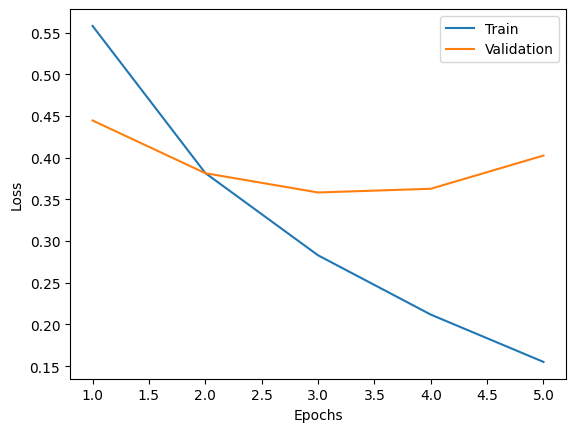

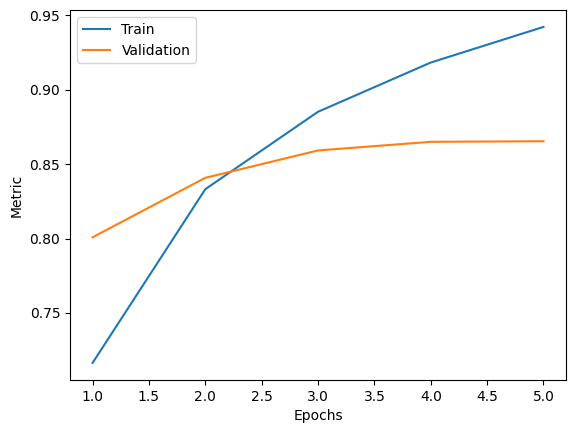

In [ ]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

**Model Checkpointing**

In [ ]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'twolayer'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/data/models/imdb/nn/2024-02-12_09-14-19_twolayer.pt')

In [ ]:
# Save the model's state dictionary to the specified file path
torch.save(model_imdb.state_dict(), path)


**Evaluate model on validation dataset**

We will now plot the confusion matrix to understand the performance of our model in more detail, particularly how well it classifies each class. For thet, we first need to get the predictions and labels.

In [ ]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)
    running_correct = 0
    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            _, outputs, correct = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            _, predicted = torch.max(outputs.data, 1)

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets.to(device)))
            running_correct += correct

    # Calculate accuracy by comparing the predicted and actual labels
    accuracy = running_correct / len(data_loader.dataset)

    # Return tuple containing predictions and accuracy
    return predictions, y, accuracy

In [ ]:
# Get the prediction and accuracy
predictions_valid, labels_valid, acc_valid = get_acc_pred(valid_loader, model_imdb, device)

In [ ]:
# Print Test Accuracy
print('Valid accuracy', acc_valid * 100)

Valid accuracy 86.53999999999999


In [ ]:
def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(valid_labels, valid_preds, normalize='true')

    # Plot the confusion matrix using Seaborn
    # 'ax' represents the axes of the plot. Seaborn's heatmap is used for visualizing the confusion matrix
    # 'annot=True' displays the values in the cells, and 'fmt' specifies the string formatting for these values
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)

    # Rotating the tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Adding labels and title to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

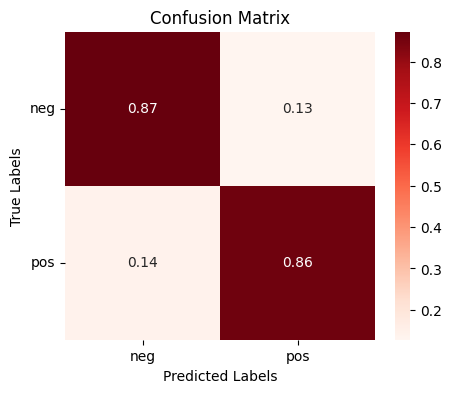

In [ ]:
plot_confusion_matrix(labels_valid.cpu().numpy(), predictions_valid.cpu().numpy(), class_labels=['neg', 'pos'])

The confusion matrix indicates that the model has a higher rate of correctly predicting both negative (neg) and positive (pos) classes, with accuracy scores of 0.87 and 0.86 respectively. However, there is still a notable proportion of false negatives (0.14) and false positives (0.13), suggesting that while the model is quite reliable, there are still some instances where it confuses one class for the other. Further refinement of the model could focus on reducing these misclassifications.

# <Font color = 'indianred'>**9 Model Testing or Expected Performance**

In [ ]:
trained_model_imdb = SimpleMLP(vocab_size=VOCAB_SIZE,
                       embedding_dim=EMBED_DIM,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       num_outputs=NUM_OUTPUTS)

checkpoint = torch.load(path)
trained_model_imdb.load_state_dict(checkpoint)

<All keys matched successfully>

**Evaluate Model on Test Set**

In [ ]:
# Get the prediction and accuracy
predictions_test, labels_test, acc_test = get_acc_pred(test_loader, trained_model_imdb, device)

In [ ]:
# Print Test Accuracy
print('Test accuracy', acc_test * 100)

Test accuracy 84.36


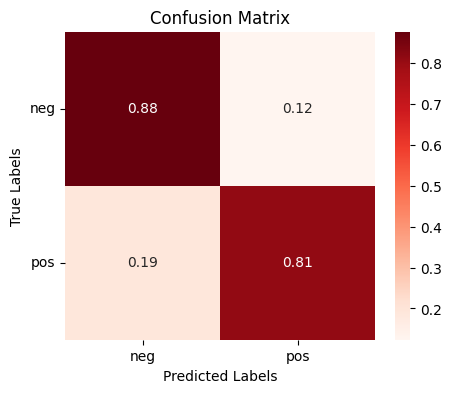

In [ ]:
plot_confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy(), class_labels=['neg', 'pos'])

# <Font color = 'indianred'>**10. Inference**:  Make predictions on new data using trained model



The inference pipleine involves following steps

**1. Preprocessing**: We will need to do the same preprocessing that we have done while training the model :
  1. Convert text in to list of indices using the vocab created using training dataset.
  2. Concatenate all text indices into a single tensor
  2. Compute the offsets

**2. Get predictions**
  1. Move model to approproiate device
  2. Put the model in evaluation mode
  3. Pass indices and offsets to model to get predictions (logits)

**3. Post processing**:
  1. Convert predictions to class labels
  2. Map class labels to class names

In [ ]:
sample_X = X_test_cleaned[0:5]

*Step 1. Preprocessing*

In [ ]:
device = 'cpu'

# Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
list_of_list_of_indices = [tokenizer(text, imdb_vocab) for text in sample_X]

# Compute the offsets for each text in the concatenated tensor
offsets = [0] + [len(i) for i in list_of_list_of_indices]
offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

# Concatenate all text indices into a single tensor
indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

*Step 2: Get Predictions*

In [ ]:
# move model to appropriate device
trained_model_imdb.to(device)

# put model in evaluation mode
trained_model_imdb.eval()

# get outputs (logits) from model
outputs = trained_model_imdb((indices, offsets))

*Step 3: Post Processing*

In [ ]:
# get predicted labels
predictions = torch.argmax(outputs, dim = 1)

# mapping for class labels
mapping = {0: 'neg', 1: 'pos'}

predicted_label_names = list(map(mapping.get, predictions.tolist()))

print(predicted_label_names)

['pos', 'pos', 'pos', 'neg', 'pos']


# Required reading for creating models in PyTorch

### Using `nn.Sequential` Within Models Like `SimpleMLP`

Despite its limitations, `nn.Sequential` can be effectively used within more complex models, such as `SimpleMLP`, for portions of the model that have a linear data flow:

```python
class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super(SimpleMLP, self).__init__()

        # Embedding layer
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

        # Sequential blocks
        self.block1 = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim1),
            nn.Dropout(drop_prob1)
        )

        self.block2 = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim2),
            nn.Dropout(drop_prob2)
        )

        # Final Linear layer
        self.linear = nn.Linear(hidden_dim2, num_outputs)

    def forward(self, input_tuple):
        data, offsets = input_tuple
        x = self.embedding_bag(data, offsets)
        x = self.block1(x)
        x = self.block2(x)
        x = self.linear(x)
        return x
```

In `SimpleMLP`, we use `nn.Sequential` for the linear layers following the `nn.EmbeddingBag`. This demonstrates the modularity of `nn.Sequential`, allowing it to be a part of a larger, more complex model while keeping the code clean and manageable.



## Introducing Custom Blocks in PyTorch

After understanding the basics of `nn.Sequential`, we can now delve into creating custom blocks in PyTorch. Custom blocks are essentially modular, reusable components that encapsulate specific sequences of layers. This approach promotes cleaner and more maintainable code, especially in complex models.

#### Custom Block Definition

Let's analyze the `CustomBlock` class from the provided code:

```python
import torch.nn as nn

class CustomBlock(nn.Module):
    def __init__(self, input_dim, output_dim, drop_prob):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(num_features=output_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
        )

    def forward(self, x):
        return self.layers(x)
```

- **Purpose:** `CustomBlock` is designed to be a flexible, reusable block that can be integrated into various parts of a neural network.
- **Components:** It combines a linear layer, batch normalization, ReLU activation, and dropout into a single unit.
- **Usage of `nn.Sequential`:** Inside `CustomBlock`, `nn.Sequential` is used to streamline the sequence of operations.
- **Forward Method:** The `forward` method defines how the input `x` passes through these layers.

#### Integrating Custom Blocks into `CustomMLP`

Now, let's see how `CustomBlock` is utilized in a more complex model, `CustomMLP`:

```python
class CustomMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()

        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)
        self.layers = nn.Sequential(
            CustomBlock(embedding_dim, hidden_dim1, drop_prob1),
            CustomBlock(hidden_dim1, hidden_dim2, drop_prob2),
            nn.Linear(hidden_dim2, num_outputs)
        )

    def forward(self, input_tuple):
        data, offsets = input_tuple
        embed_out = self.embedding_bag(data, offsets)
        out = self.layers(embed_out)

        return out
```

- **Embedding Layer:** The `CustomMLP` model starts with an `nn.EmbeddingBag` layer, suitable for handling text data.
- **Usage of Custom Blocks:** It then employs two instances of `CustomBlock`, each with different dimensions and dropout probabilities.
- **Final Linear Layer:** A final linear layer is added to produce the output.
- **Forward Pass:** The `forward` method orchestrates the flow of data through the embedding layer and the sequential custom blocks.

#### Benefits of Custom Blocks

- **Modularity:** Custom blocks enable you to define complex sequences of operations in a single, reusable unit.
- **Readability:** They make the overall model architecture more readable and easier to understand.
- **Flexibility:** Custom blocks can be easily adjusted or replaced, making the model more adaptable to changes.

By creating and integrating custom blocks, you can build sophisticated neural network architectures in PyTorch that are both efficient and easy to manage. This approach is particularly beneficial in large-scale projects or research where modularity and readability are crucial.